In [ ]:
pip install psutil

In [ ]:
pip install power

  Preparing metadata (setup.py) ... done
  Created wheel for power: filename=power-1.4-py3-none-any.whl size=12934 sha256=745f723dc133dfe7a3b2273a68b5e90992ece42f59b1327772eddece19b395b6
  Stored in directory: /root/.cache/pip/wheels/b7/65/0c/c879816bed2002489158a33b64b195eee014a68be2c63cb4b2
Successfully built power


In [ ]:
import psutil
import time
import csv
from datetime import datetime

def get_battery_status():
    battery = psutil.sensors_battery()
    if battery is not None:
        return battery.percent
    return None

def get_cpu_usage_per_app():
    app_cpu_usage = []
    for proc in psutil.process_iter(['pid', 'name', 'cpu_percent']):
        try:
            app_cpu_usage.append({
                'pid': proc.info['pid'],
                'name': proc.info['name'],
                'cpu_percent': proc.info['cpu_percent'],
                'memory_percent': proc.memory_percent(),
                'cpu_time': proc.cpu_times(),
                'num_threads': proc.num_threads()
            })
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            pass
    return app_cpu_usage

def main():
    with open('app_power_telemetry.csv', 'w', newline='') as csvfile:
        fieldnames = ['timestamp', 'battery_percent', 'pid', 'app_name', 'cpu_percent', 'memory_percent', 'cpu_time', 'num_threads']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        end_time = time.time() + 300  # Collect data for 5 minutes
        while time.time() < end_time:
            timestamp = datetime.now().isoformat()
            battery_percent = get_battery_status()
            app_cpu_usage = get_cpu_usage_per_app()

            for app in app_cpu_usage:
                writer.writerow({
                    'timestamp': timestamp,
                    'battery_percent': battery_percent if battery_percent is not None else 'N/A',
                    'pid': app['pid'],
                    'app_name': app['name'],
                    'cpu_percent': app['cpu_percent'],
                    'memory_percent': app['memory_percent'],
                    'cpu_time': app['cpu_time'],
                    'num_threads': app['num_threads']
                })
            time.sleep(60)  # Collect data every 60 seconds

if __name__ == '__main__':
    main()


In [ ]:
import pandas as pd
path = "/content/app_power_telemetry.csv"
data = pd.read_csv(path)
data

,timestamp,battery_percent,pid,app_name,cpu_percent,memory_percent,cpu_time,num_threads
0,2024-07-06T23:41:34.036391,29,1403,distnoted,0.0,0.055695,"pcputimes(user=123.921743872, system=24.762810...",4
1,2024-07-06T23:41:34.036391,29,1459,cfprefsd,0.0,0.058746,"pcputimes(user=72.520237056, system=55.7711073...",3
2,2024-07-06T23:41:34.036391,29,1466,mdbulkimport,0.0,0.089264,"pcputimes(user=47.824388096, system=29.8399027...",2
3,2024-07-06T23:41:34.036391,29,1487,secd,0.0,0.131798,"pcputimes(user=78.539767808, system=22.7469373...",2
4,2024-07-06T23:41:34.036391,29,1489,loginwindow,0.0,0.059128,"pcputimes(user=74.183450624, system=35.6256727...",5
...,...,...,...,...,...,...,...,...
518,2024-07-06T23:42:34.075470,29,35373,iCloudNotificationAgent,0.0,0.132561,"pcputimes(user=0.15416016, system=0.15893184, ...",2
519,2024-07-06T23:42:34.075470,29,35382,OSDUIHelper,0.0,0.175095,"pcputimes(user=0.078671544, system=0.112288496...",3
520,2024-07-06T23:42:34.075470,29,35384,CategoriesService,0.0,0.120926,"pcputimes(user=0.045480624, system=0.055354456...",3
521,2024-07-06T23:42:34.075470,29,35387,python,0.0,0.005150,"pcputimes(user=0.022203666, system=0.030552584...",1


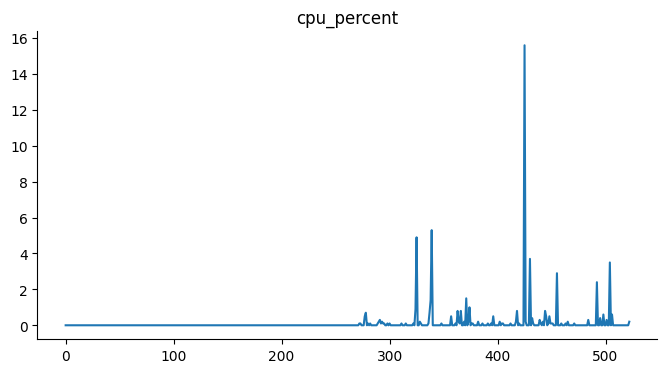

In [ ]:
from matplotlib import pyplot as plt
data['cpu_percent'].plot(kind='line', figsize=(8, 4), title='cpu_percent')
plt.gca().spines[['top', 'right']].set_visible(False)

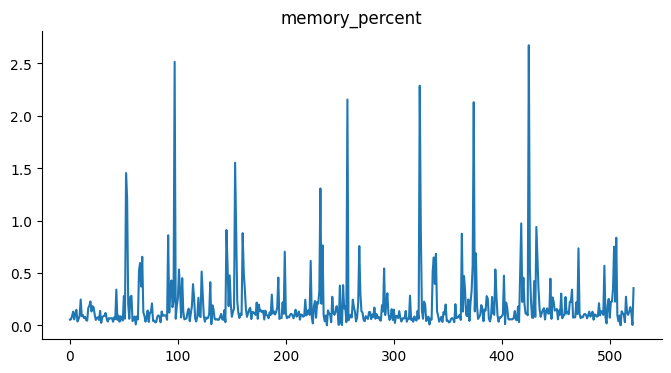

In [ ]:
from matplotlib import pyplot as plt
data['memory_percent'].plot(kind='line', figsize=(8, 4), title='memory_percent')
plt.gca().spines[['top', 'right']].set_visible(False)

# Collection of Initial data and Limited data

In [ ]:
import psutil
import time
import csv
import subprocess
from datetime import datetime

def get_battery_status():
    battery = psutil.sensors_battery()
    if battery is not None:
        return battery.percent
    return None

def get_cpu_usage_per_app():
    app_cpu_usage = []
    for proc in psutil.process_iter(['pid', 'name', 'cpu_percent']):
        try:
            app_cpu_usage.append({
                'pid': proc.info['pid'],
                'name': proc.info['name'],
                'cpu_percent': proc.info['cpu_percent'],
                'memory_percent': proc.memory_percent(),
                'cpu_time': proc.cpu_times(),
                'num_threads': proc.num_threads()
            })
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            pass
    return app_cpu_usage

def limit_cpu_usage(pid, priority):
    # Adjust the priority of the process using the 'renice' command
    subprocess.run(['renice', '-n', str(priority), '-p', str(pid)])

def collect_data(file_name, duration):
    with open(file_name, 'w', newline='') as csvfile:
        fieldnames = ['timestamp', 'battery_percent', 'pid', 'app_name', 'cpu_percent', 'memory_percent', 'cpu_time', 'num_threads']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        end_time = time.time() + duration  # Collect data for the specified duration
        while time.time() < end_time:
            timestamp = datetime.now().isoformat()
            battery_percent = get_battery_status()
            app_cpu_usage = get_cpu_usage_per_app()

            for app in app_cpu_usage:
                writer.writerow({
                    'timestamp': timestamp,
                    'battery_percent': battery_percent if battery_percent is not None else 'N/A',
                    'pid': app['pid'],
                    'app_name': app['name'],
                    'cpu_percent': app['cpu_percent'],
                    'memory_percent': app['memory_percent'],
                    'cpu_time': app['cpu_time'],
                    'num_threads': app['num_threads']
                })
            time.sleep(60)  # Collect data every 60 seconds

def main():
    # Collect initial data
    collect_data('app_power_telemetry_initial.csv', 300)  # Collect data for 5 minutes

    # Adjust CPU usage limits (simulate by adjusting process priorities)
    processes = psutil.process_iter(['pid', 'name'])
    for proc in processes:
        try:
            if proc.info['name']:  # Only adjust for processes with a name
                limit_cpu_usage(proc.info['pid'], 10)  # Adjust to a lower priority to limit CPU usage
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            pass

    # Collect data after limiting CPU usage
    collect_data('app_power_telemetry_limited.csv', 300)  # Collect data for another 5 minutes

if __name__ == '__main__':
    main()


In [ ]:
import pandas as pd
path = "/content/app_power_telemetry_initial.csv"
data = pd.read_csv(path)
data

,timestamp,battery_percent,pid,app_name,cpu_percent,memory_percent,cpu_time,num_threads
0,2024-07-06T23:58:15.184394,26,1403,distnoted,0.2,0.055504,"pcputimes(user=125.212516352, system=24.968536...",4
1,2024-07-06T23:58:15.184394,26,1459,cfprefsd,0.1,0.054359,"pcputimes(user=73.167552512, system=56.2719703...",3
2,2024-07-06T23:58:15.184394,26,1466,mdbulkimport,0.2,0.115776,"pcputimes(user=48.595226624, system=30.2913699...",2
3,2024-07-06T23:58:15.184394,26,1487,secd,0.0,0.069237,"pcputimes(user=78.643879936, system=22.8555980...",2
4,2024-07-06T23:58:15.184394,26,1489,loginwindow,0.0,0.109291,"pcputimes(user=74.383040512, system=35.8323814...",5
...,...,...,...,...,...,...,...,...
751,2024-07-07T00:00:15.359645,26,36206,VTDecoderXPCService,0.0,0.087929,"pcputimes(user=0.035842, system=0.045756664, c...",8
752,2024-07-07T00:00:15.359645,26,36370,businessservicesd,0.0,0.103378,"pcputimes(user=0.05481104, system=0.063274168,...",2
753,2024-07-07T00:00:15.359645,26,36398,CommCenter,0.0,0.164223,"pcputimes(user=0.07155192, system=0.15149504, ...",5
754,2024-07-07T00:00:15.359645,26,36421,replayd,0.0,0.154305,"pcputimes(user=2.897833216, system=0.485564512...",3


In [ ]:
import pandas as pd
path = "/content/app_power_telemetry_limited.csv"
data = pd.read_csv(path)
data

,timestamp,battery_percent,pid,app_name,cpu_percent,memory_percent,cpu_time,num_threads
0,2024-07-07T00:03:16.408786,26,1403,distnoted,0.1,0.055504,"pcputimes(user=125.551599616, system=25.023873...",4
1,2024-07-07T00:03:16.408786,26,1459,cfprefsd,0.1,0.054359,"pcputimes(user=73.343000576, system=56.4098662...",3
2,2024-07-07T00:03:16.408786,26,1466,mdbulkimport,0.0,0.104713,"pcputimes(user=48.596033536, system=30.2934405...",2
3,2024-07-07T00:03:16.408786,26,1487,secd,0.0,0.095749,"pcputimes(user=78.689353728, system=22.9041295...",2
4,2024-07-07T00:03:16.408786,26,1489,loginwindow,0.0,0.092888,"pcputimes(user=74.39822848, system=35.87286220...",5
...,...,...,...,...,...,...,...,...
1038,2024-07-07T00:06:16.530204,25,35490,com.apple.geod,0.1,0.137329,"pcputimes(user=0.417935488, system=0.529238176...",4
1039,2024-07-07T00:06:16.530204,25,35807,python3.11,0.1,0.194931,"pcputimes(user=2.563399168, system=2.204521728...",21
1040,2024-07-07T00:06:16.530204,25,35892,com.apple.appkit.xpc.openAndSavePanelService,0.0,0.343323,"pcputimes(user=3.523373568, system=1.457680128...",4
1041,2024-07-07T00:06:16.530204,25,35893,QuickLookUIService,0.0,0.157738,"pcputimes(user=0.044161084, system=0.104467712...",5


# Comparison of the intial data and the limited data

In [ ]:
import pandas as pd

# Load the data
initial_data = pd.read_csv('app_power_telemetry_initial.csv')
limited_data = pd.read_csv('app_power_telemetry_limited.csv')

# Group by application name and calculate the average CPU usage
initial_avg_cpu = initial_data.groupby('app_name')['cpu_percent'].mean()
limited_avg_cpu = limited_data.groupby('app_name')['cpu_percent'].mean()

# Compare the average CPU usage
comparison = pd.DataFrame({
    'initial_avg_cpu': initial_avg_cpu,
    'limited_avg_cpu': limited_avg_cpu
}).reset_index()

# Calculate the change in CPU usage
comparison['cpu_usage_change'] = comparison['limited_avg_cpu'] - comparison['initial_avg_cpu']

print(comparison)


                     app_name  initial_avg_cpu  limited_avg_cpu  \
0     AMPDeviceDiscoveryAgent         0.000000             0.00   
1              AirPlayUIAgent         0.000000             0.00   
2                  AppleSpell         0.033333             0.05   
3    AssetCacheLocatorService              NaN             0.00   
4     AudioComponentRegistrar         0.000000             0.00   
..                        ...              ...              ...   
192                    trustd         0.166667             0.05   
193          universalaccessd         0.000000             0.00   
194             useractivityd         0.000000             0.00   
195                 usernoted         0.033333             0.00   
196        usernotificationsd         0.000000             0.00   

     cpu_usage_change  
0            0.000000  
1            0.000000  
2            0.016667  
3                 NaN  
4            0.000000  
..                ...  
192         -0.116667  
193

# Visualization of the intial data and the limited data


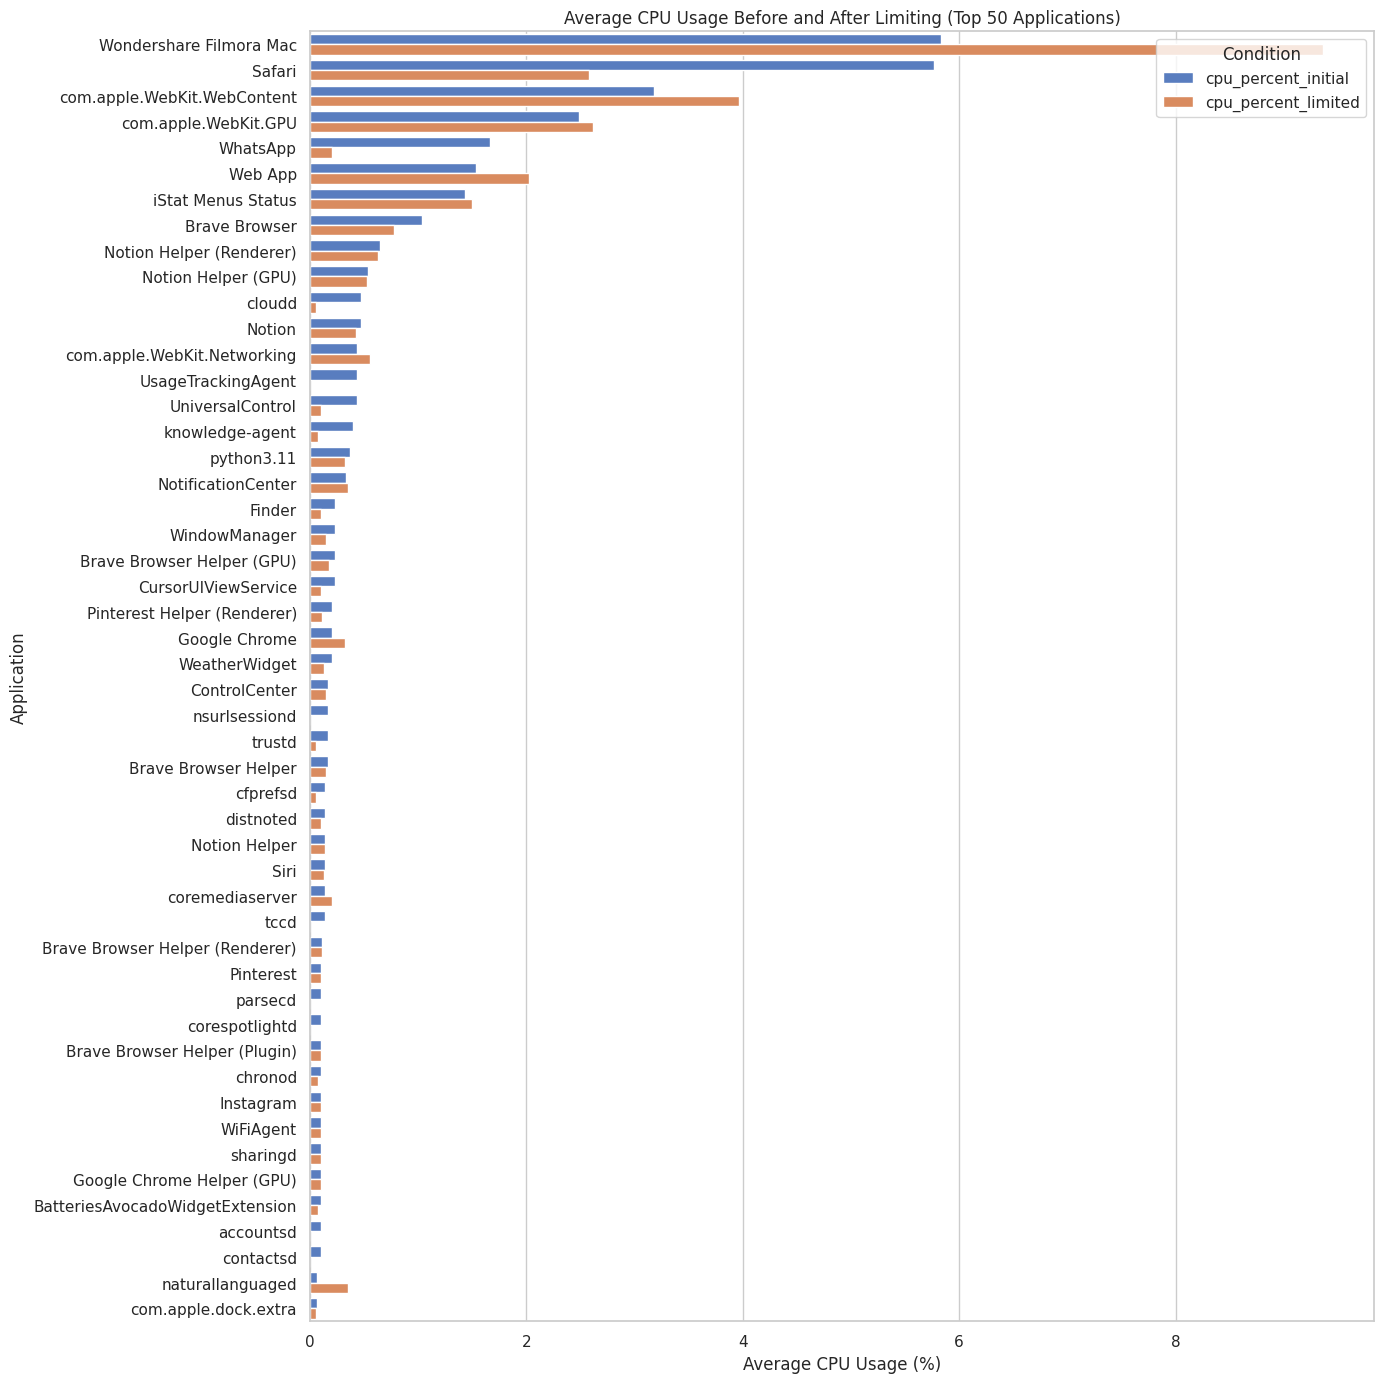

<ipython-input-14-12b314392bec>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cpu_usage_change', y='app_name', data=top_comparison, palette='coolwarm')


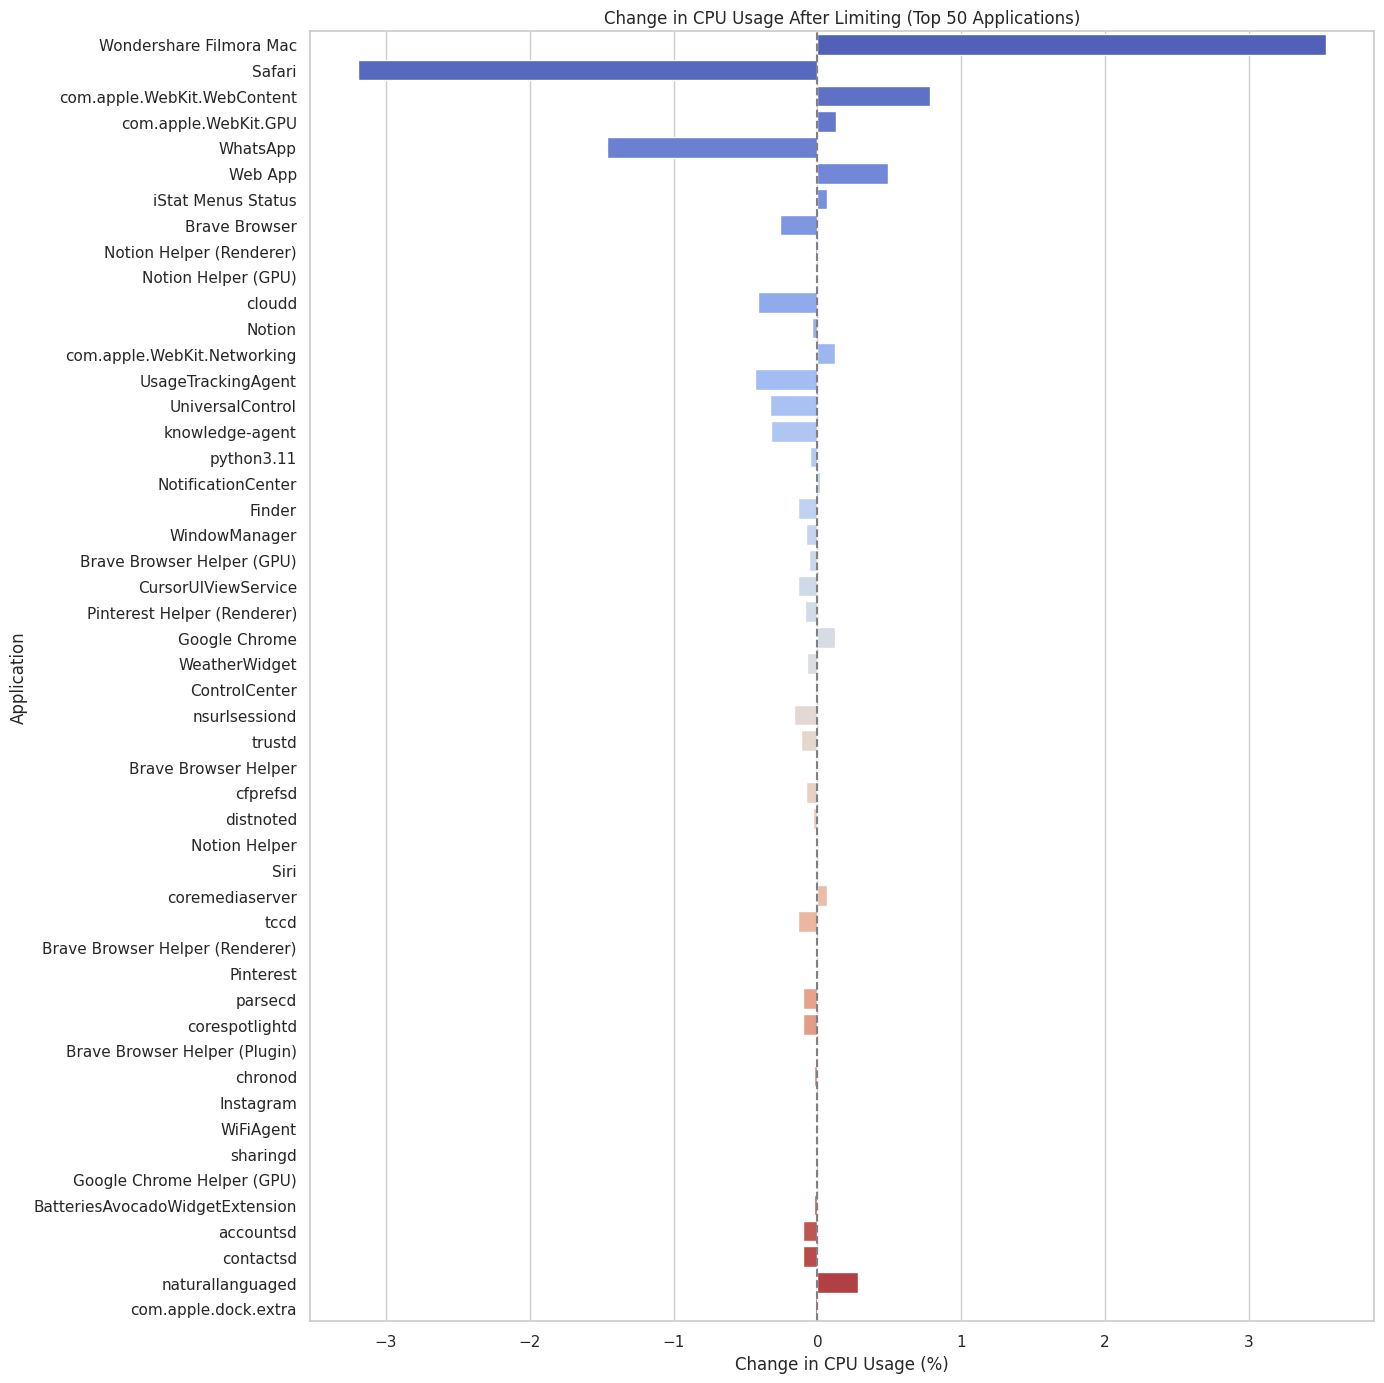

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
initial_data = pd.read_csv('app_power_telemetry_initial.csv')
limited_data = pd.read_csv('app_power_telemetry_limited.csv')

# Group by application name and calculate the average CPU usage
initial_avg_cpu = initial_data.groupby('app_name')['cpu_percent'].mean().reset_index()
limited_avg_cpu = limited_data.groupby('app_name')['cpu_percent'].mean().reset_index()

# Merge the data on app_name
comparison = pd.merge(initial_avg_cpu, limited_avg_cpu, on='app_name', suffixes=('_initial', '_limited'))

# Calculate the change in CPU usage
comparison['cpu_usage_change'] = comparison['cpu_percent_limited'] - comparison['cpu_percent_initial']

# Sort by initial CPU usage and limit to top 50
top_comparison = comparison.sort_values(by='cpu_percent_initial', ascending=False).head(50)

# Plot the comparison
plt.figure(figsize=(14, 14))
sns.set(style="whitegrid")

# Bar plot of average CPU usage before and after limiting
top_comparison_melted = pd.melt(top_comparison, id_vars='app_name', value_vars=['cpu_percent_initial', 'cpu_percent_limited'],
                                var_name='Condition', value_name='CPU Usage (%)')

sns.barplot(x='CPU Usage (%)', y='app_name', hue='Condition', data=top_comparison_melted, palette='muted')

plt.title('Average CPU Usage Before and After Limiting (Top 50 Applications)')
plt.xlabel('Average CPU Usage (%)')
plt.ylabel('Application')
plt.legend(title='Condition', loc='upper right')
plt.tight_layout()
plt.show()

# Plot the change in CPU usage
plt.figure(figsize=(14, 14))
sns.barplot(x='cpu_usage_change', y='app_name', data=top_comparison, palette='coolwarm')

plt.title('Change in CPU Usage After Limiting (Top 50 Applications)')
plt.xlabel('Change in CPU Usage (%)')
plt.ylabel('Application')
plt.axvline(0, color='grey', linestyle='--')
plt.tight_layout()
plt.show()


# Limiting CPU to 80%


In [ ]:
import psutil
import time
import csv
from datetime import datetime
import subprocess

def get_battery_status():
    battery = psutil.sensors_battery()
    if battery is not None:
        return battery.percent
    return None

def get_cpu_usage_per_app():
    app_cpu_usage = []
    for proc in psutil.process_iter(['pid', 'name', 'cpu_percent']):
        try:
            app_cpu_usage.append({
                'pid': proc.info['pid'],
                'name': proc.info['name'],
                'cpu_percent': proc.info['cpu_percent'],
                'memory_percent': proc.memory_percent(),
                'cpu_time': proc.cpu_times(),
                'num_threads': proc.num_threads()
            })
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            pass
    return app_cpu_usage

def limit_cpu_usage(pid, cpu_percent):
    # Simulate CPU usage limitation by adjusting process priority
    subprocess.run(['renice', '-n', str(cpu_percent), '-p', str(pid)], stdout=subprocess.PIPE)

def collect_data(file_name, duration):
    with open(file_name, 'w', newline='') as csvfile:
        fieldnames = ['timestamp', 'battery_percent', 'pid', 'app_name', 'cpu_percent', 'memory_percent', 'cpu_time', 'num_threads']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        end_time = time.time() + duration  # Collect data for the specified duration
        while time.time() < end_time:
            timestamp = datetime.now().isoformat()
            battery_percent = get_battery_status()
            app_cpu_usage = get_cpu_usage_per_app()

            for app in app_cpu_usage:
                writer.writerow({
                    'timestamp': timestamp,
                    'battery_percent': battery_percent if battery_percent is not None else 'N/A',
                    'pid': app['pid'],
                    'app_name': app['name'],
                    'cpu_percent': app['cpu_percent'],
                    'memory_percent': app['memory_percent'],
                    'cpu_time': app['cpu_time'],
                    'num_threads': app['num_threads']
                })
            time.sleep(60)  # Collect data every 60 seconds

def main():
    duration = 300  # Duration to collect data in seconds (5 minutes)
    file_prefix = 'app_power_telemetry'

    # Collect initial data
    collect_data(f'{file_prefix}_initial.csv', duration)

    # Adjust CPU usage limits (simulate by adjusting process priorities)
    processes = psutil.process_iter(['pid', 'name'])
    for proc in processes:
        try:
            if proc.info['name']:  # Only adjust for processes with a name
                limit_cpu_usage(proc.info['pid'], 80)
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            pass

    # Collect data after limiting CPU usage
    collect_data(f'{file_prefix}_limited_80.csv', duration)

if __name__ == '__main__':
    main()


In [ ]:
import pandas as pd
path = "limited_80.csv"
a = pd.read_csv(path)
a

,timestamp,battery_percent,pid,app_name,cpu_percent,memory_percent,cpu_time,num_threads
0,2024-07-07T20:52:17.581484,73,1403,distnoted,0.2,0.056839,"pcputimes(user=140.515885056, system=27.875272...",4
1,2024-07-07T20:52:17.581484,73,1459,cfprefsd,0.1,0.054169,"pcputimes(user=83.642302464, system=62.9202001...",4
2,2024-07-07T20:52:17.581484,73,1466,mdbulkimport,0.0,0.090599,"pcputimes(user=49.164075008, system=30.7159511...",2
3,2024-07-07T20:52:17.581484,73,1487,secd,0.0,0.131798,"pcputimes(user=84.969537536, system=25.4641561...",2
4,2024-07-07T20:52:17.581484,73,1489,loginwindow,0.0,0.124741,"pcputimes(user=79.30642432, system=38.88531456...",5
...,...,...,...,...,...,...,...,...
800,2024-07-07T20:54:17.661202,73,44243,contactsd,0.0,0.114632,"pcputimes(user=1.691542144, system=0.588552512...",2
801,2024-07-07T20:54:17.661202,73,44244,calaccessd,0.0,0.189590,"pcputimes(user=0.49971504, system=0.23686296, ...",5
802,2024-07-07T20:54:17.661202,73,44245,IntelligencePlatformComputeService,0.0,0.139427,"pcputimes(user=0.566814144, system=0.210906128...",2
803,2024-07-07T20:54:17.661202,73,44246,com.apple.geod,0.0,0.169563,"pcputimes(user=0.113619832, system=0.224799952...",3


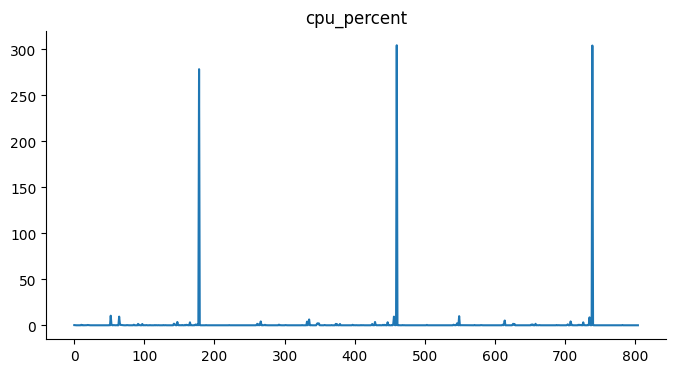

In [ ]:
from matplotlib import pyplot as plt
a['cpu_percent'].plot(kind='line', figsize=(8, 4), title='cpu_percent')
plt.gca().spines[['top', 'right']].set_visible(False)

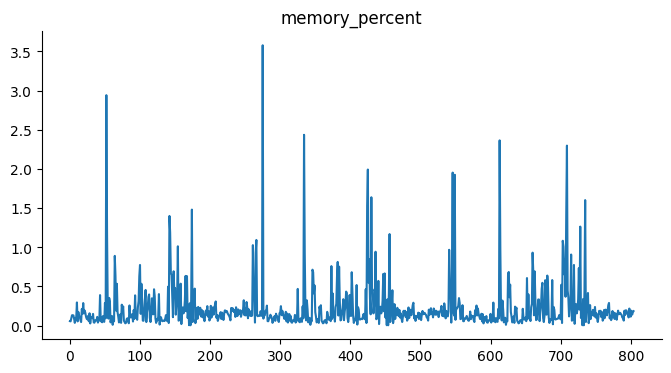

In [ ]:
from matplotlib import pyplot as plt
a['memory_percent'].plot(kind='line', figsize=(8, 4), title='memory_percent')
plt.gca().spines[['top', 'right']].set_visible(False)

# Limiting CPU to 50%


In [ ]:
def main():
    duration = 300  # Duration to collect data in seconds (5 minutes)
    file_prefix = 'app_power_telemetry'

    # Collect initial data
    collect_data(f'{file_prefix}_initial.csv', duration)

    # Adjust CPU usage limits (simulate by adjusting process priorities)
    processes = psutil.process_iter(['pid', 'name'])
    for proc in processes:
        try:
            if proc.info['name']:  # Only adjust for processes with a name
                limit_cpu_usage(proc.info['pid'], 50)
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            pass

    # Collect data after limiting CPU usage
    collect_data(f'{file_prefix}_limited_50.csv', duration)

if __name__ == '__main__':
    main()


In [ ]:
import pandas as pd
path = "limited_50.csv"
a = pd.read_csv(path)
a

,timestamp,battery_percent,pid,app_name,cpu_percent,memory_percent,cpu_time,num_threads
0,2024-07-07T21:03:39.759831,71,1403,distnoted,0.1,0.055313,"pcputimes(user=141.180583936, system=27.983155...",4
1,2024-07-07T21:03:39.759831,71,1459,cfprefsd,0.0,0.049973,"pcputimes(user=83.813244928, system=63.0693232...",2
2,2024-07-07T21:03:39.759831,71,1466,mdbulkimport,0.0,0.088882,"pcputimes(user=49.164169216, system=30.7164282...",2
3,2024-07-07T21:03:39.759831,71,1487,secd,0.0,0.102997,"pcputimes(user=84.999995392, system=25.5040409...",2
4,2024-07-07T21:03:39.759831,71,1489,loginwindow,0.0,0.094795,"pcputimes(user=79.344386048, system=38.9550120...",5
...,...,...,...,...,...,...,...,...
1440,2024-07-07T21:07:39.974437,71,46049,biomesyncd,0.0,0.167084,"pcputimes(user=0.074333792, system=0.049978664...",2
1441,2024-07-07T21:07:39.974437,71,46053,AuthenticationServicesAgent,0.0,0.219917,"pcputimes(user=0.163091328, system=0.11784804,...",7
1442,2024-07-07T21:07:39.974437,71,46060,promotedcontentd,0.0,0.235558,"pcputimes(user=0.171511632, system=0.089682416...",7
1443,2024-07-07T21:07:39.974437,71,46061,keychainsharingmessagingd,0.0,0.138664,"pcputimes(user=0.036063832, system=0.015947583...",7


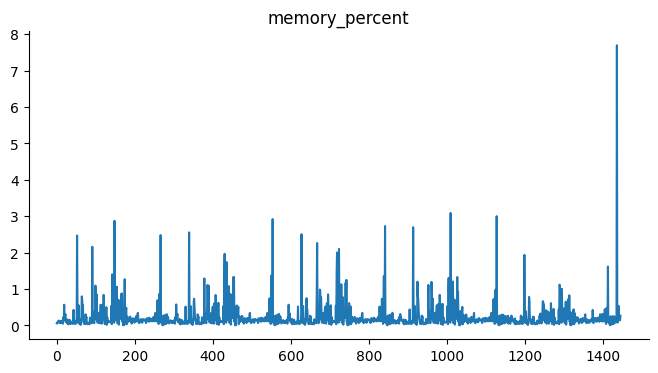

In [ ]:
from matplotlib import pyplot as plt
a['memory_percent'].plot(kind='line', figsize=(8, 4), title='memory_percent')
plt.gca().spines[['top', 'right']].set_visible(False)

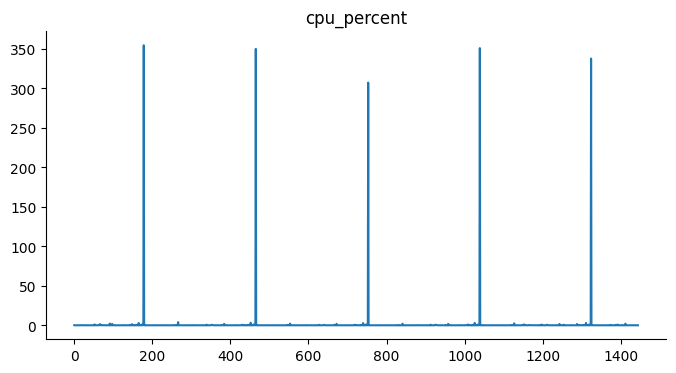

In [ ]:
a['cpu_percent'].plot(kind='line', figsize=(8, 4), title='cpu_percent')
plt.gca().spines[['top', 'right']].set_visible(False)

# Limiting CPU to 30%

In [ ]:
def main():
    duration = 300  # Duration to collect data in seconds (5 minutes)
    file_prefix = 'app_power_telemetry'

    # Collect initial data
    collect_data(f'{file_prefix}_initial.csv', duration)

    # Adjust CPU usage limits (simulate by adjusting process priorities)
    processes = psutil.process_iter(['pid', 'name'])
    for proc in processes:
        try:
            if proc.info['name']:  # Only adjust for processes with a name
                limit_cpu_usage(proc.info['pid'], 30)
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            pass

    # Collect data after limiting CPU usage
    collect_data(f'{file_prefix}_limited_30.csv', duration)

if __name__ == '__main__':
    main()

In [ ]:
import pandas as pd
path = "limited_30.csv"
a = pd.read_csv(path)
a

,timestamp,battery_percent,pid,app_name,cpu_percent,memory_percent,cpu_time,num_threads
0,2024-07-07T22:50:53.670429,69,1403,distnoted,0.1,0.055885,"pcputimes(user=142.591606784, system=28.226369...",4
1,2024-07-07T22:50:53.670429,69,1459,cfprefsd,0.1,0.055885,"pcputimes(user=84.484096, system=63.579598848,...",2
2,2024-07-07T22:50:53.670429,69,1466,mdbulkimport,0.0,0.057983,"pcputimes(user=49.170358272, system=30.7327037...",2
3,2024-07-07T22:50:53.670429,69,1487,secd,0.0,0.105858,"pcputimes(user=85.803614208, system=25.8729062...",2
4,2024-07-07T22:50:53.670429,69,1489,loginwindow,0.0,0.147057,"pcputimes(user=80.78721024, system=39.84095232...",5
...,...,...,...,...,...,...,...,...
1448,2024-07-07T22:54:53.866905,68,47059,Google Chrome Helper (Renderer),0.2,1.106834,"pcputimes(user=0.660698624, system=0.319752448...",17
1449,2024-07-07T22:54:53.866905,68,47067,com.apple.SiriTTSService.TrialProxy,0.0,0.089264,"pcputimes(user=0.029974832, system=0.030490332...",2
1450,2024-07-07T22:54:53.866905,68,47127,mdworker_shared,0.0,0.241470,"pcputimes(user=0.088060664, system=0.038237248...",3
1451,2024-07-07T22:54:53.866905,68,47128,mdworker_shared,0.1,0.241280,"pcputimes(user=0.097369208, system=0.039054376...",4


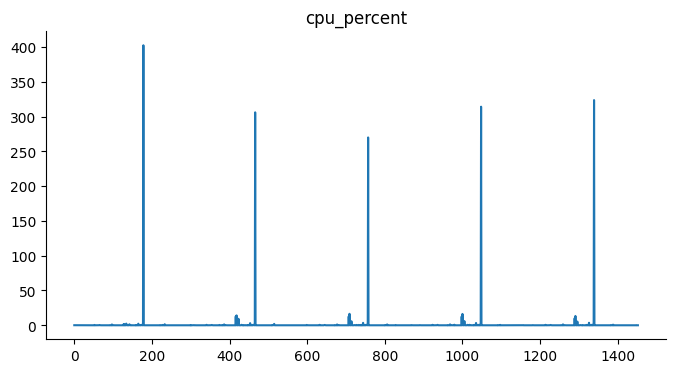

In [ ]:
from matplotlib import pyplot as plt
a['cpu_percent'].plot(kind='line', figsize=(8, 4), title='cpu_percent')
plt.gca().spines[['top', 'right']].set_visible(False)

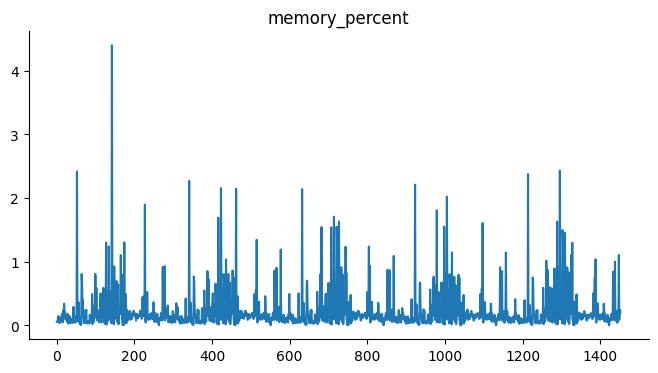

In [ ]:
# @title memory_percent

from matplotlib import pyplot as plt
a['memory_percent'].plot(kind='line', figsize=(8, 4), title='memory_percent')
plt.gca().spines[['top', 'right']].set_visible(False)

# Camparison of  CPU performance in 80%, 50% and 30%

In [ ]:
import pandas as pd

# Load the data for different CPU limitations
initial_data = pd.read_csv('app_power_telemetry_initial.csv')
limited_data_80 = pd.read_csv('limited_80.csv')
limited_data_50 = pd.read_csv('limited_50.csv')
limited_data_30 = pd.read_csv('limited_30.csv')

# Function to group by application name and calculate the average CPU usage
def calculate_avg_cpu(data):
    return data.groupby('app_name')['cpu_percent'].mean()

# Calculate average CPU usage for initial and limited data
initial_avg_cpu = calculate_avg_cpu(initial_data)
limited_avg_cpu_80 = calculate_avg_cpu(limited_data_80)
limited_avg_cpu_50 = calculate_avg_cpu(limited_data_50)
limited_avg_cpu_30 = calculate_avg_cpu(limited_data_30)

# Compare the average CPU usage and calculate the change for each limitation
comparison_80 = pd.DataFrame({
    'initial_avg_cpu': initial_avg_cpu,
    'limited_avg_cpu_80': limited_avg_cpu_80
}).reset_index()
comparison_80['cpu_usage_change_80'] = comparison_80['limited_avg_cpu_80'] - comparison_80['initial_avg_cpu']

comparison_50 = pd.DataFrame({
    'initial_avg_cpu': initial_avg_cpu,
    'limited_avg_cpu_50': limited_avg_cpu_50
}).reset_index()
comparison_50['cpu_usage_change_50'] = comparison_50['limited_avg_cpu_50'] - comparison_50['initial_avg_cpu']

comparison_30 = pd.DataFrame({
    'initial_avg_cpu': initial_avg_cpu,
    'limited_avg_cpu_30': limited_avg_cpu_30
}).reset_index()
comparison_30['cpu_usage_change_30'] = comparison_30['limited_avg_cpu_30'] - comparison_30['initial_avg_cpu']

# Combine all comparisons into a single DataFrame
comparison_combined = pd.merge(comparison_80, comparison_50, on='app_name', suffixes=('_80', '_50'))
comparison_combined = pd.merge(comparison_combined, comparison_30, on='app_name')

# Print the comparison results
print(comparison_combined)

# Save the comparison results to a CSV file
comparison_combined.to_csv('cpu_usage_comparison.csv', index=False)


                     app_name  initial_avg_cpu_80  limited_avg_cpu_80  \
0     AMPDeviceDiscoveryAgent            0.000000            0.000000   
1              AirPlayUIAgent            0.000000            0.000000   
2                  AppleSpell            0.033333            0.050000   
3    AssetCacheLocatorService                 NaN            0.000000   
4     AudioComponentRegistrar            0.000000            0.000000   
..                        ...                 ...                 ...   
207                    trustd            0.166667            0.066667   
208          universalaccessd            0.000000            0.000000   
209             useractivityd            0.000000            0.000000   
210                 usernoted            0.033333            0.000000   
211        usernotificationsd            0.000000            0.000000   

     cpu_usage_change_80  initial_avg_cpu_50  limited_avg_cpu_50  \
0               0.000000            0.000000           

In [ ]:
import pandas as pd

# Load the data
initial_data = pd.read_csv('app_power_telemetry_initial.csv')
limited_data_80 = pd.read_csv('app_power_telemetry_limited_80.csv')
limited_data_50 = pd.read_csv('app_power_telemetry_limited_50.csv')
limited_data_30 = pd.read_csv('app_power_telemetry_limited_30.csv')

# Group by application name and calculate the average CPU usage
initial_avg_cpu = initial_data.groupby('app_name')['cpu_percent'].mean().nlargest(50)
limited_avg_cpu_80 = limited_data_80.groupby('app_name')['cpu_percent'].mean().reindex(initial_avg_cpu.index)
limited_avg_cpu_50 = limited_data_50.groupby('app_name')['cpu_percent'].mean().reindex(initial_avg_cpu.index)
limited_avg_cpu_30 = limited_data_30.groupby('app_name')['cpu_percent'].mean().reindex(initial_avg_cpu.index)

# Create a DataFrame for comparison
comparison = pd.DataFrame({
    'app_name': initial_avg_cpu.index,
    'cpu_percent_initial': initial_avg_cpu.values,
    'cpu_percent_limited_80': limited_avg_cpu_80.values,
    'cpu_percent_limited_50': limited_avg_cpu_50.values,
    'cpu_percent_limited_30': limited_avg_cpu_30.values
})

# Calculate the change in CPU usage
comparison['cpu_usage_change_80'] = comparison['cpu_percent_limited_80'] - comparison['cpu_percent_initial']
comparison['cpu_usage_change_50'] = comparison['cpu_percent_limited_50'] - comparison['cpu_percent_initial']
comparison['cpu_usage_change_30'] = comparison['cpu_percent_limited_30'] - comparison['cpu_percent_initial']

print(comparison)


                           app_name  cpu_percent_initial  \
0           Wondershare Filmora Mac             5.833333   
1                            Safari             5.766667   
2       com.apple.WebKit.WebContent             3.181481   
3              com.apple.WebKit.GPU             2.483333   
4                          WhatsApp             1.666667   
5                           Web App             1.533333   
6                iStat Menus Status             1.433333   
7                     Brave Browser             1.033333   
8          Notion Helper (Renderer)             0.644444   
9               Notion Helper (GPU)             0.533333   
10                           cloudd             0.466667   
11                           Notion             0.466667   
12               UsageTrackingAgent             0.433333   
13      com.apple.WebKit.Networking             0.433333   
14                 UniversalControl             0.433333   
15                  knowledge-agent     

# Visualization

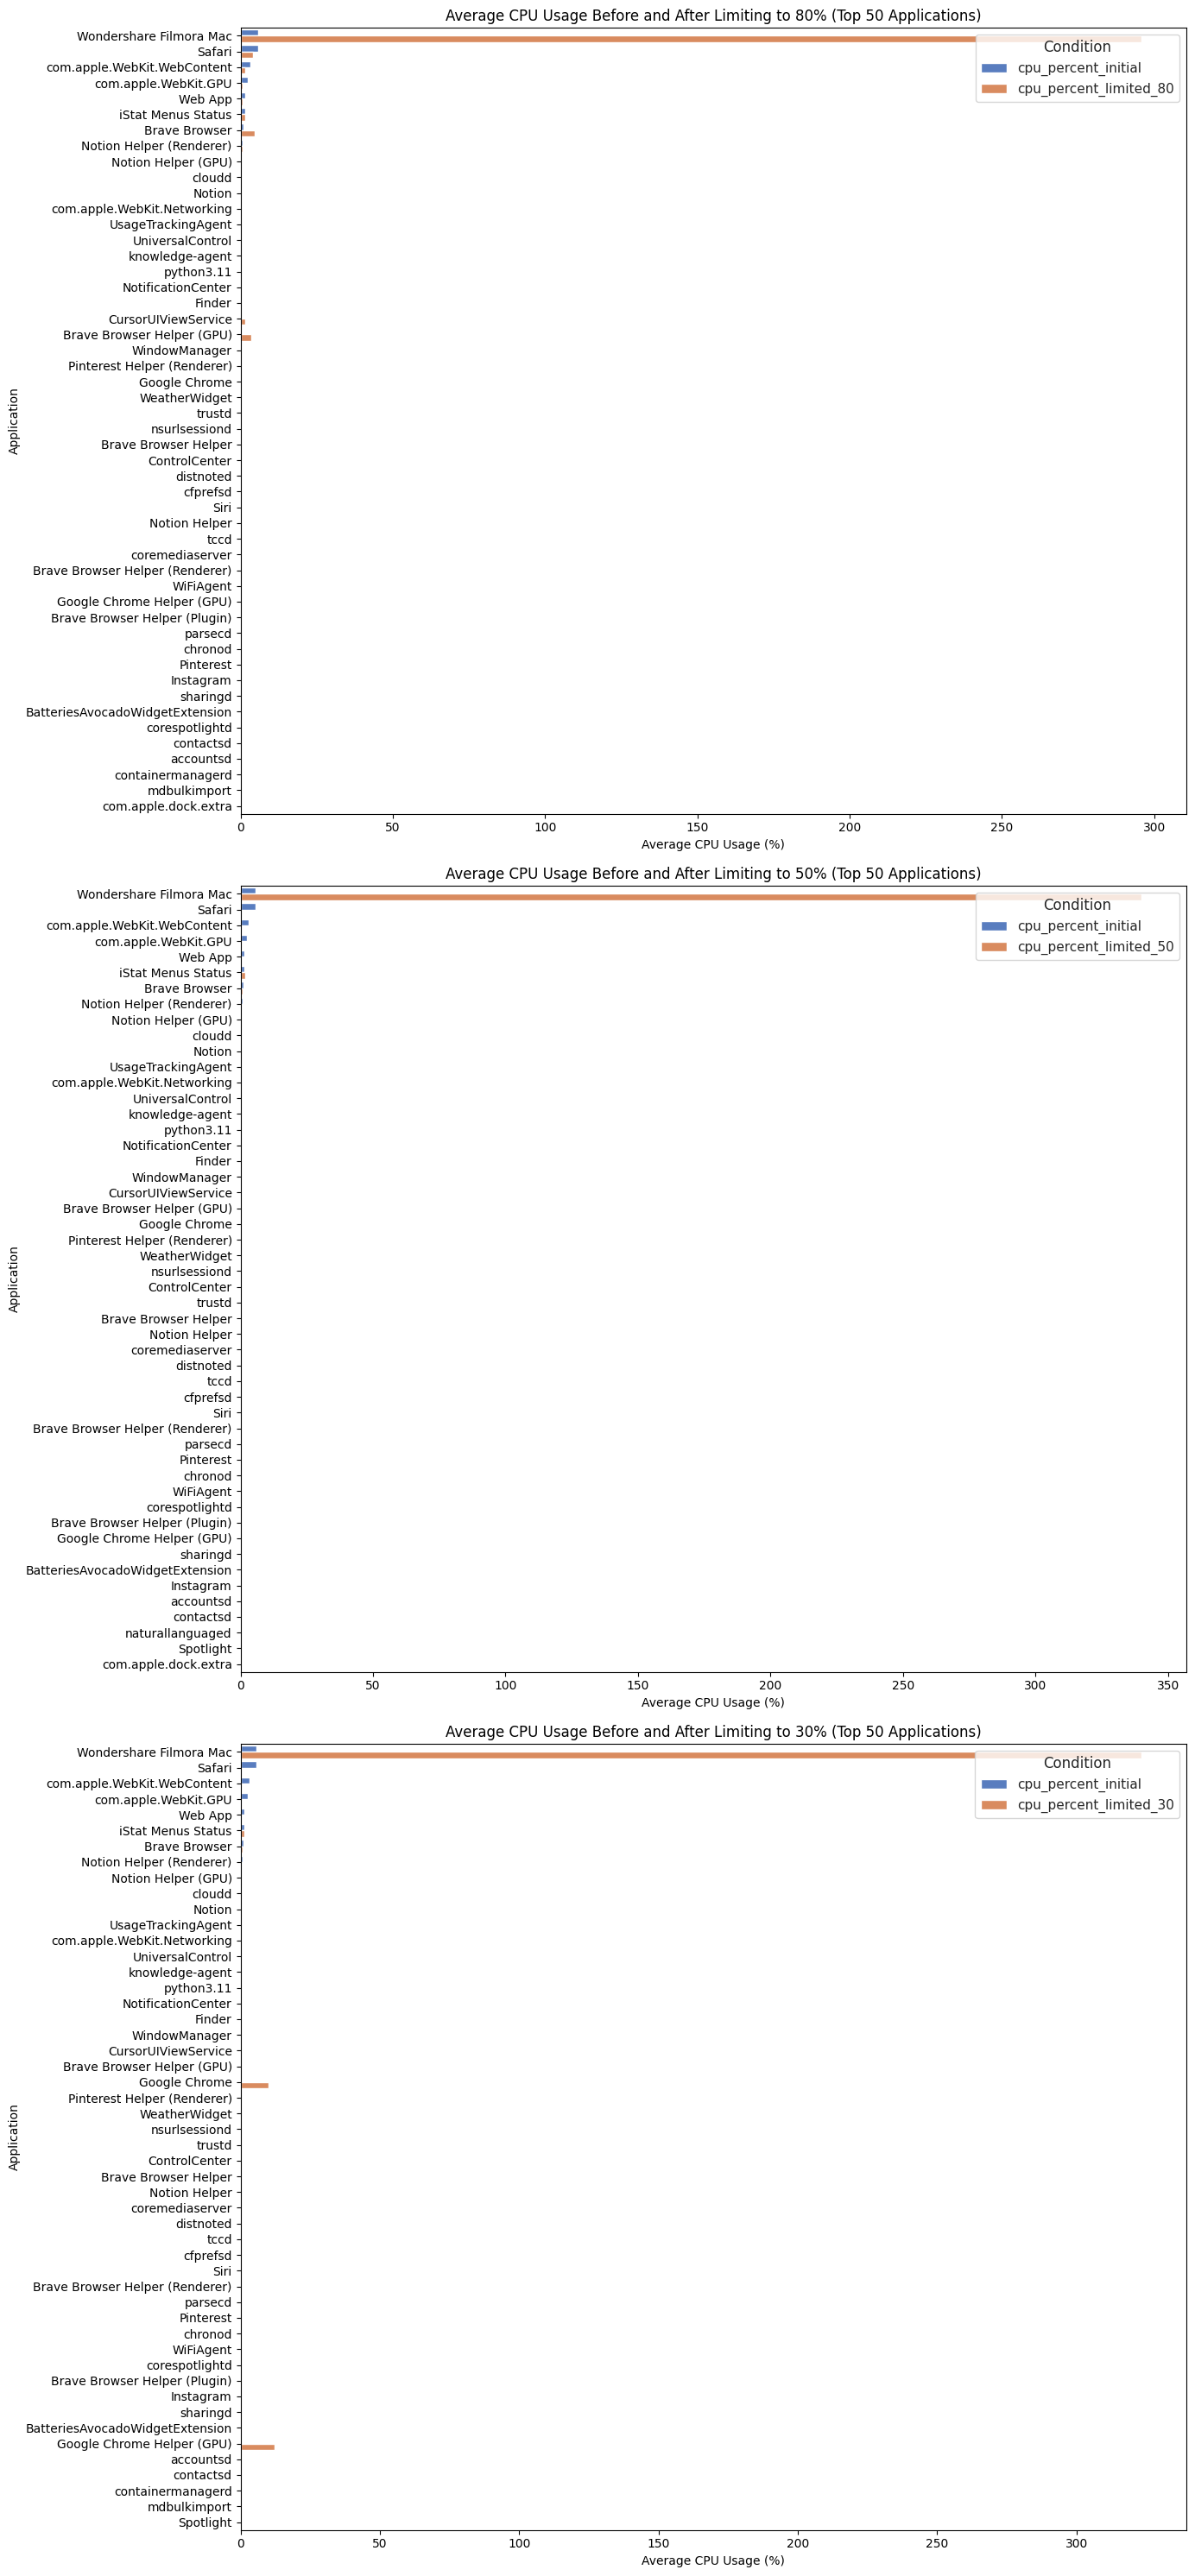

<ipython-input-11-4beacc5e11cd>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f'cpu_usage_change_{limit}', y='app_name', data=top_comparison, palette='coolwarm', ax=axes[i])
<ipython-input-11-4beacc5e11cd>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f'cpu_usage_change_{limit}', y='app_name', data=top_comparison, palette='coolwarm', ax=axes[i])
<ipython-input-11-4beacc5e11cd>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f'cpu_usage_change_{limit}', y='app_name', data=top_comparison, palette='coolwarm', ax=axes[i])


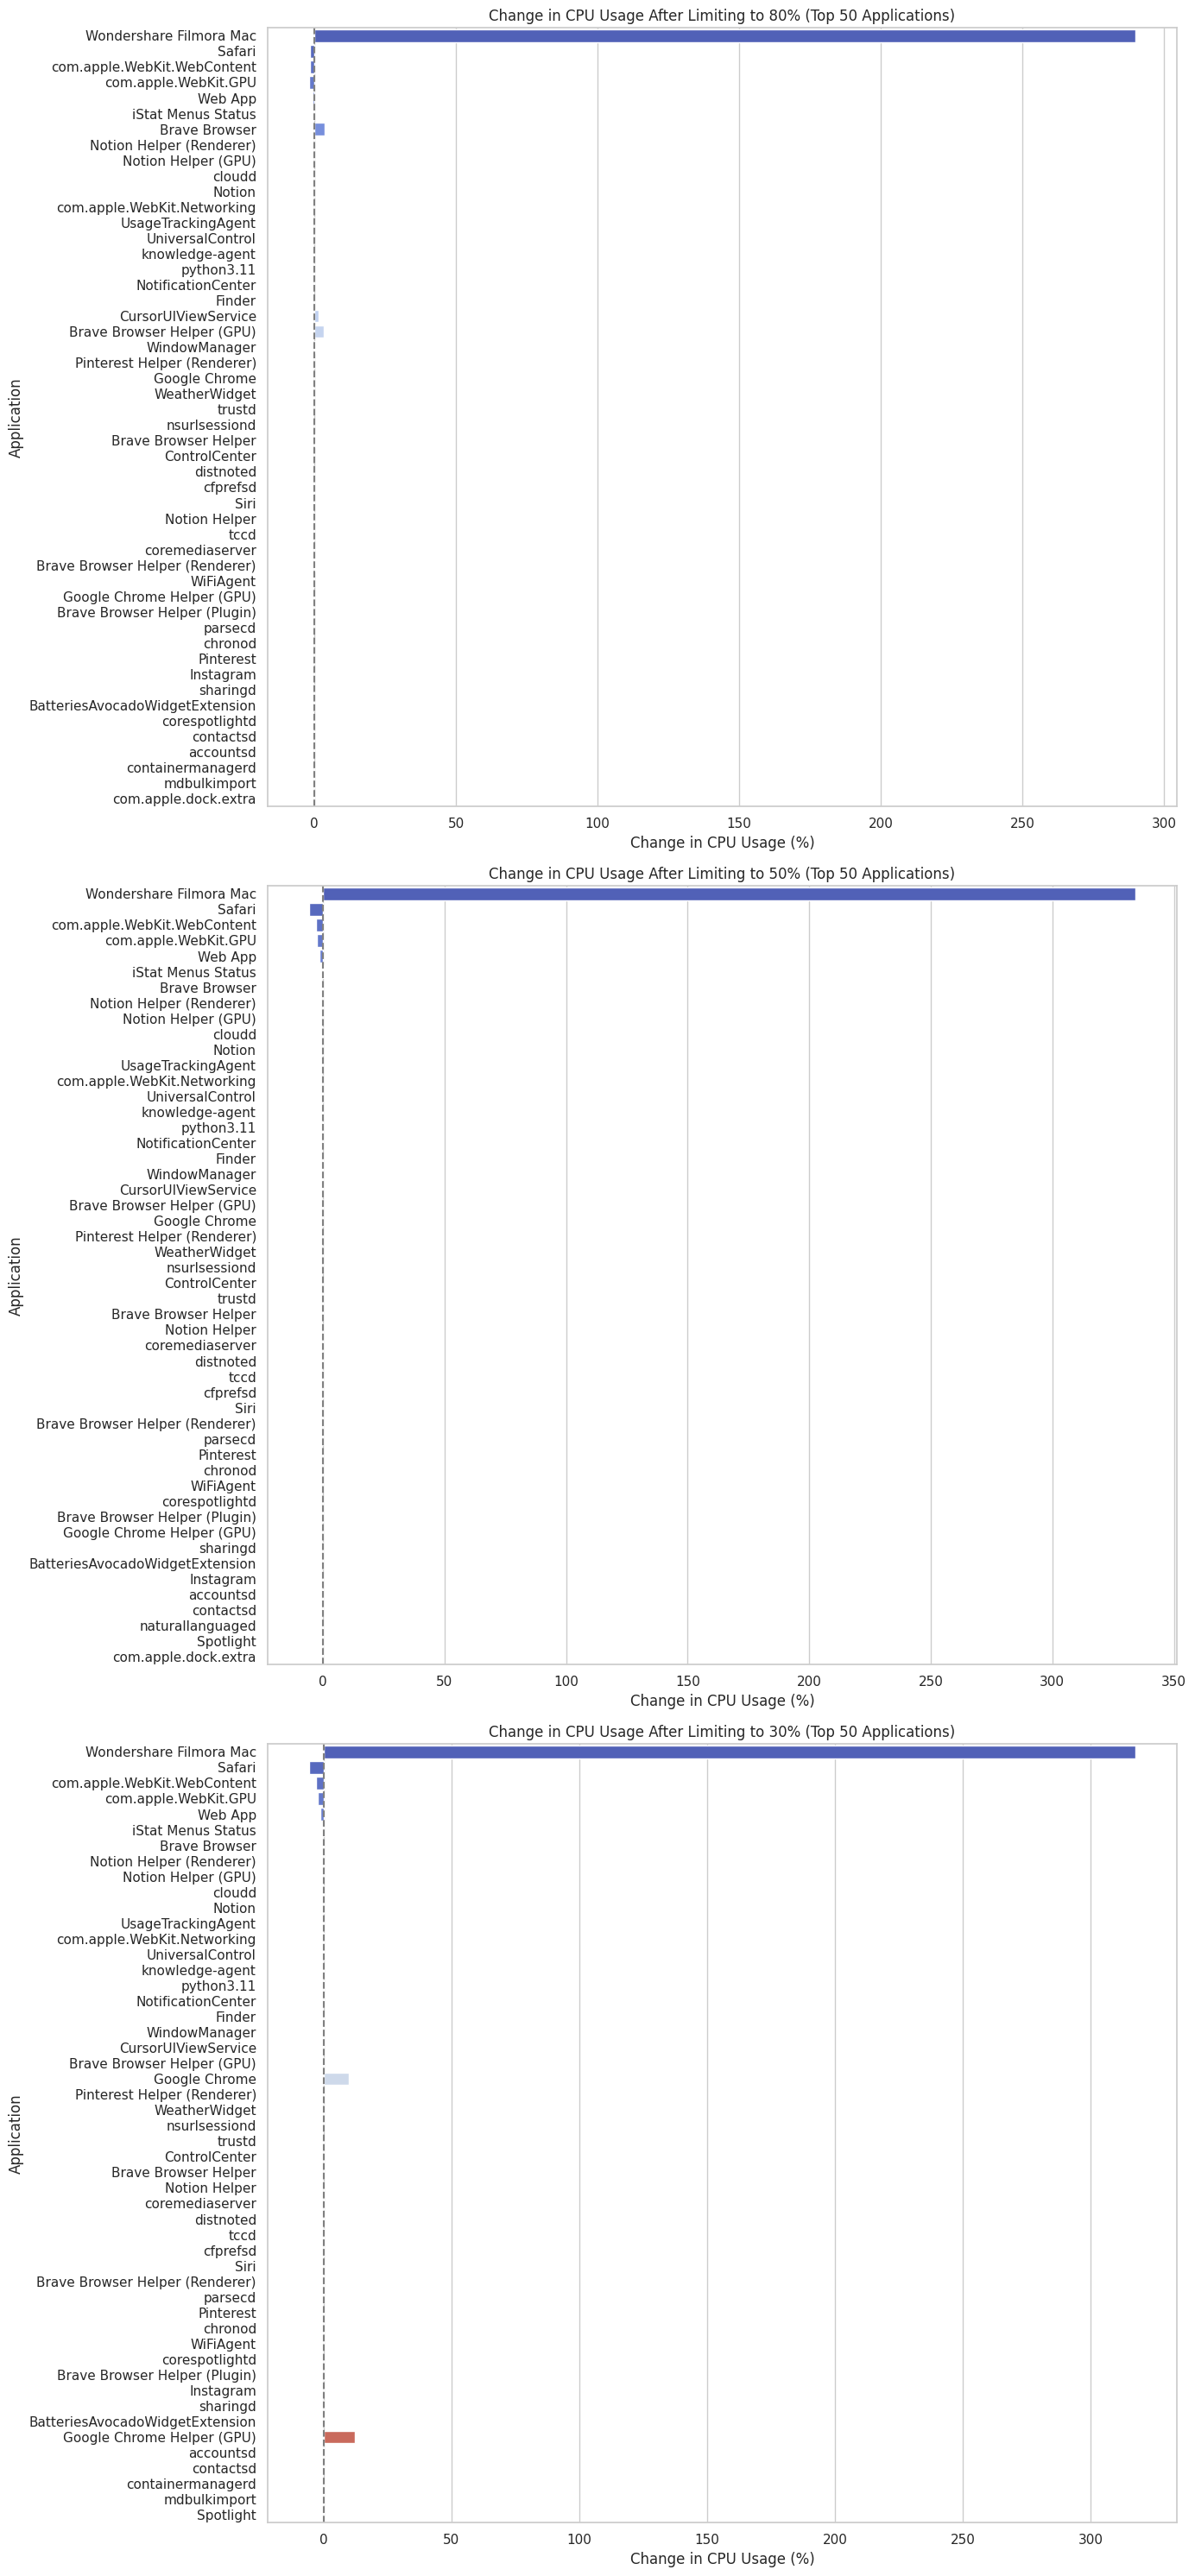

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_comparison(limits, file_prefix):
    initial_data = pd.read_csv(f'{file_prefix}_initial.csv')

    fig, axes = plt.subplots(len(limits), 1, figsize=(14, 10 * len(limits)))

    for i, limit in enumerate(limits):
        limited_data = pd.read_csv(f'{file_prefix}_limited_{limit}.csv')

        initial_avg_cpu = initial_data.groupby('app_name')['cpu_percent'].mean().reset_index()
        limited_avg_cpu = limited_data.groupby('app_name')['cpu_percent'].mean().reset_index()

        comparison = pd.merge(initial_avg_cpu, limited_avg_cpu, on='app_name', suffixes=('_initial', f'_limited_{limit}'))
        comparison[f'cpu_usage_change_{limit}'] = comparison[f'cpu_percent_limited_{limit}'] - comparison['cpu_percent_initial']

        top_comparison = comparison.sort_values(by='cpu_percent_initial', ascending=False).head(50)

        sns.set(style="whitegrid")
        top_comparison_melted = pd.melt(top_comparison, id_vars='app_name', value_vars=['cpu_percent_initial', f'cpu_percent_limited_{limit}'],
                                        var_name='Condition', value_name='CPU Usage (%)')

        sns.barplot(x='CPU Usage (%)', y='app_name', hue='Condition', data=top_comparison_melted, palette='muted', ax=axes[i])
        axes[i].set_title(f'Average CPU Usage Before and After Limiting to {limit}% (Top 50 Applications)')
        axes[i].set_xlabel('Average CPU Usage (%)')
        axes[i].set_ylabel('Application')
        axes[i].legend(title='Condition', loc='upper right')

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(len(limits), 1, figsize=(14, 10 * len(limits)))

    for i, limit in enumerate(limits):
        limited_data = pd.read_csv(f'{file_prefix}_limited_{limit}.csv')

        initial_avg_cpu = initial_data.groupby('app_name')['cpu_percent'].mean().reset_index()
        limited_avg_cpu = limited_data.groupby('app_name')['cpu_percent'].mean().reset_index()

        comparison = pd.merge(initial_avg_cpu, limited_avg_cpu, on='app_name', suffixes=('_initial', f'_limited_{limit}'))
        comparison[f'cpu_usage_change_{limit}'] = comparison[f'cpu_percent_limited_{limit}'] - comparison['cpu_percent_initial']

        top_comparison = comparison.sort_values(by='cpu_percent_initial', ascending=False).head(50)

        sns.set(style="whitegrid")
        sns.barplot(x=f'cpu_usage_change_{limit}', y='app_name', data=top_comparison, palette='coolwarm', ax=axes[i])
        axes[i].set_title(f'Change in CPU Usage After Limiting to {limit}% (Top 50 Applications)')
        axes[i].set_xlabel('Change in CPU Usage (%)')
        axes[i].set_ylabel('Application')
        axes[i].axvline(0, color='grey', linestyle='--')

    plt.tight_layout()
    plt.show()

def main():
    limits = [80, 50, 30]  # CPU limits to apply
    file_prefix = 'app_power_telemetry'
    visualize_comparison(limits, file_prefix)

if __name__ == '__main__':
    main()
